# Exercise 5 - Python: Regularized Linear Regression and Bias vs. Variance

## *Part I*: Regularized Linear Regression

Predicting the amount of water flowing out of a dam using the change of water level in a reservoir

Part I is primarily setup for creating a regularized logistic regression model before diving into the new concepts for this exercise

---

Beginning with package imports, data loading, and initial visualization

In [1]:
import numpy as np
import pandas as pd
import altair
import scipy.io as sio  # Used to load the Octave/MATLAB *.mat files
from scipy import optimize

In [2]:
# Reading in the .mat file
data = sio.loadmat('ex5/ex5data1.mat')

# Unpacking values from the .mat file
# Training set for fitting the models
X = data['X']
y = data['y']

# Validation set for determining the regularization parameter
Xval = data['Xval']
yval = data['yval']

# Test set for evaluating performance
Xtest = data['Xtest']
ytest = data['ytest']

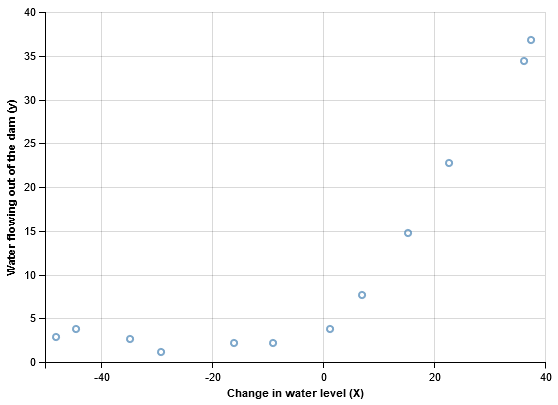

In [3]:
# Creating a data frame since altair requires it as input
df = pd.DataFrame({'X': X.flatten(), 'y': y.flatten()})

# Plotting the data
altair.Chart(df).mark_point().encode(
    x=altair.X('X:Q', axis=altair.Axis(title='Change in water level (X)')),
    y=altair.Y('y:Q', axis=altair.Axis(title='Water flowing out of the dam (y)')))

### Regularized cost function

$J(\theta) = \frac{1}{2m} \big(\sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})^2 \big) + \frac{\lambda}{2m} \big( \sum_{j=1}^n \theta_j^2 \big)$

In [4]:
def cost_function(theta, X, y, C=0.0):
    """
    Calculates the cost for regularized linear regression
    """
    m = y.size
    
    # Adding the intercept term if it doesn't exist
    if X.shape[1] == 1 or X[:, 0].mean() != 0:
        X = np.insert(X, 0, 1, axis=1)
    
    h = X.dot(theta.reshape(-1, 1))  # Generating predictions
    error = np.sum((h - y)**2)  # Calculating squared error
    regParam = (C/(2*m)) * np.sum(np.power(theta[1:], 2))
    
    J = (1/(2*m)) * error + regParam  # Calculating total cost
    
    return J

# Initial values to test our functions and use for theta optimization
initialTheta = np.ones(2)

cost_function(initialTheta, X, y, 1.0)

303.99319222026429

### Regularized gradient

$\frac{\partial J(\theta)}{\partial \theta_j} = \begin{cases} 
\hspace{0.25cm} \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)} & \text{for}\ j = 0 \\
\Big(\frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}\Big) + \frac{\lambda}{m}\theta_j & \text{for}\ j \geq 1
\end{cases}$

In [5]:
def gradient(theta, X, y, C=0.0):
    """
    Calculates the gradient for regularized linear regression
    """
    m = y.size
    
    # Adding the intercept term if it doesn't exist
    if X.shape[1] == 1 or X[:, 0].mean() != 1:
        X = np.insert(X, 0, 1, axis=1)
        
    h = X.dot(theta.reshape(-1, 1))

    # Calculating the regularization parameter for all thetas but the intercept
    regParam = (C/m)*theta[1:]
    
    gradient = (1/m)*(X.T.dot(h-y))
    gradient[1:] = gradient[1:] + regParam  # Applying the reg parameter
    return gradient


gradient(initialTheta, X, y, 1.0)

array([[ -15.30301567],
       [ 598.25074417]])

### Fitting linear regression

In [6]:
def fit_model(thetas, X, y, C=0.0):
    """
    Helper function for optimizing the thetas for the regularized
    linear regression model
    """
    # Finding values of theta that minimize the cost function
    fitted = optimize.fmin(func=cost_function,  # Function to minimize
                           x0=thetas,  # Initial guess
                           args=(X, y, C),  # Additional Arguments
                           maxiter=4000,
                           disp=False)  # Removes # iterations performed
    return fitted


optimalTheta = fit_model(initialTheta, X, y)
optimalTheta

array([ 13.08791065,   0.36778096])

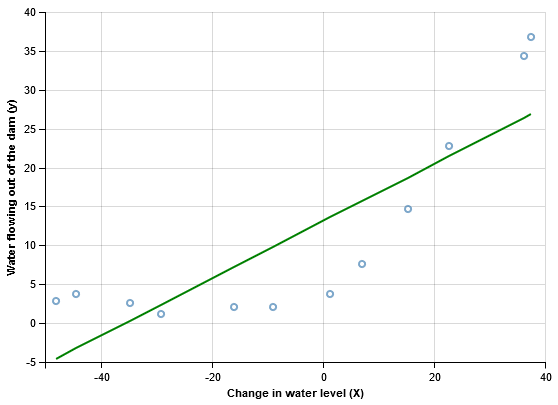

In [7]:
# Generating predictions
df['Prediction'] = optimalTheta[0] + df['X'] * optimalTheta[1]

# Creating the initial object for layering charts
chart = altair.LayeredChart(df)

# Plotting original data
chart += altair.Chart(df).mark_point().encode(
            x=altair.X('X:Q', axis=altair.Axis(title='Change in water level (X)')),
            y=altair.Y('y:Q', axis=altair.Axis(title='Water flowing out of the dam (y)')))

# Adding the fitting line
chart += altair.Chart(df).mark_line(color='green').encode(
            x='X:Q',
            y='Prediction:Q')

# Rendering the output
chart.display()

---

##  *Part II:* Bias-Variance

**[Talk about bias-variance tradeoff]**

<img src="http://www.kdnuggets.com/wp-content/uploads/bias-and-variance.jpg" style="width: 350px">

A high bias leads to overfitting, and a high variance leads to underfitting.  Trying to minimize both tends to result in a good generalized fit that will perform well on data that the model hasn't seen before.

[This blog post](http://scott.fortmann-roe.com/docs/BiasVariance.html) does an exceptional job at explaining the bias-variance tradeoff in further detail

### Learning curves

Learning curves are an excellent way to show the bias and variance of our model.  They are a graph of the error of both the validation set and the training set by the number of training examples.  The shape of these errors will help us deduce the bias/variance of the model.  Here are examples showing the cases of high/low bias/variance (note: this is a transposed version of the targets shown above):

<img src="http://www.ultravioletanalytics.com/wp-content/uploads/2014/12/bias_variance_chart1.jpg"style="width: 450px">

$J_{train}(\theta) = \frac{1}{2m} \big[ \sum_{i=1}^m (h_{\theta}(x^{(o)})-y^{(i)})^2 \big]$

$J_{validation}(\theta) = \frac{1}{2m_{validation}} \big[ \sum_{i=1}^{m_{validation}} (h_{\theta}(x_{validation}^{(o)})-y_{validation}^{(i)})^2 \big]$

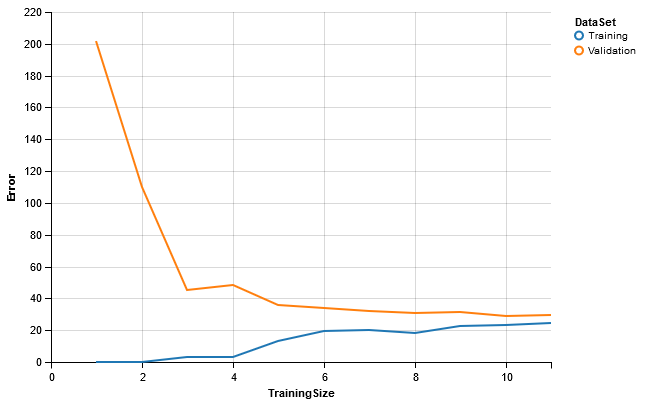

In [8]:
def plot_learning_curve(Xtrain, ytrain, Xval, yval, C=0.0):
    """
    Plots the learning curve of the regularized logistic regression 
    """
    m = ytrain.size

    # Creating empty lists to add the error to
    trainingError = []
    validationError = []

    # Looping through training sizes to calculate our errors
    for i in range(1, m):

        # Optimizing theta with the given training size
        thetas = fit_model(np.zeros(2), Xtrain[:i], ytrain[:i], C)

        # Calculating the training error
        trainingError.append(cost_function(thetas, Xtrain[:i], ytrain[:i],
                                           0))  # Excluding reg parameter

        # Calculating the validation error
        validationError.append(cost_function(thetas, Xval, yval,
                                             0))  # Excluding reg parameter

    # Storing the training error in a data frame
    results = pd.DataFrame(trainingError, columns=['Error'])
    results['DataSet'] = 'Training'
    results['TrainingSize'] = range(1, m)

    # Storing the validation error in a data frame
    validation = pd.DataFrame(validationError, columns=['Error'])
    validation['DataSet'] = 'Validation'
    validation['TrainingSize'] = range(1, m)

    # Joining the two into one data frame
    results = results.append(validation, ignore_index=True)

    # Plotting the data
    learning_curve = altair.Chart(results).mark_line().encode(
        x='TrainingSize:Q',
        y='Error:Q',
        color='DataSet:N')

    return learning_curve


plot_learning_curve(X, y, Xval, yval)

This model is suffering from high bias, which we could have inferred from plotting the fitting curve in the first section

---

##  *Part III:* Polynomial Regression

In [9]:
def map_polynomial(X, order):
    """
    Maps X up to the polynomial orders specified
    """
    Xpoly = X.copy()
    
    if order <= 1:
        return X
    
    for i in range(2, order+1):
        Xpoly = np.insert(arr=Xpoly, obj=i-1, values=np.power(X.flatten(), i), axis=1)
    
    return Xpoly

power = 6

map_polynomial(X, power).shape

(12, 6)

### Learning Polynomial Regression

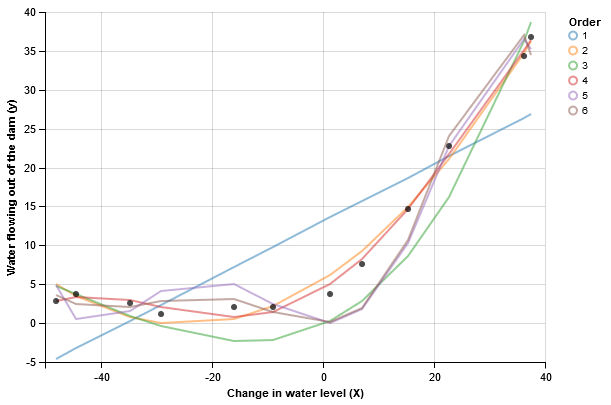

In [10]:
dfPoly = df.copy()

# Generating predictions for the orders specified
for order in range(2, power+1):
    Xpoly = map_polynomial(X, order)
    optimalTheta = fit_model(np.zeros(order+1), Xpoly, y)
    prediction = optimalTheta[0] + np.sum(optimalTheta[1:] * Xpoly, axis=1)
    dfPoly = dfPoly.append(pd.DataFrame({'Prediction': prediction, 'X': X.flatten(), 'Order': order}))
    
dfPoly['Order'].fillna(1, inplace=True)

# Creating the initial object for layering charts
chart = altair.LayeredChart(dfPoly)

# Plotting the fitting lines
chart += altair.Chart(dfPoly).mark_line(opacity=0.5).encode(
            x=altair.X('X:Q', axis=altair.Axis(title='Change in water level (X)')),
            y=altair.Y('Prediction:Q', axis=altair.Axis(title='Water flowing out of the dam (y)')),
            color='Order:N')

# Plotting original data
chart += altair.Chart(dfPoly).mark_circle(color='black').encode(
            x='X:Q',
            y='y:Q')

# Rendering the output
chart.display()

### (Optional) Adjusting the regularization parameter

### Selecting $\lambda$ using a cross validation set

### (Optional)  Computing test set error

### (Optional) Plotting learning curves with randomly selected examples